In [1]:
from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
from pydy.system import System
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# init_printing(False)
init_printing(True)
from IPython.display import set_matplotlib_formats
import InputShaping as shaping
set_matplotlib_formats('retina')

In [2]:
# Constants
Length_1 = 2
Length_2 = 1
Length_3 = 3
Mass = 2.3

def s_curve(CurrTime, Begin, Amp, RiseTime, StartTime):
    """
    This was copied from Dr. Vaughan's Input shaping Library
    I edited it to allow for a beginning value.

    Function to generate an s-curve command

    Arguments:
      CurrTime : The current timestep or an array of times
      Amp : The magnitude of the s-curve (or final setpoint)
      RiseTime : The rise time of the curve
      StartTime : The time that the command should StartTime
      Begin : The beginnning value

    Returns :
      The command at the current timestep or an array representing the command
      over the times given (if CurrTime was an array)
    """

    Amp = Amp - Begin
    scurve = (2.0 * ((CurrTime - StartTime)/RiseTime)**2 *
    (CurrTime-StartTime >= 0) * (CurrTime-StartTime < RiseTime/2)
    +(-2.0 * ((CurrTime - StartTime)/RiseTime)**2 + 4.0 * ((CurrTime -
    StartTime)/RiseTime) - 1.0) * (CurrTime-StartTime >= RiseTime/2) *
    (CurrTime-StartTime < RiseTime) + 1.0 * (CurrTime-StartTime >= RiseTime))

    return (Amp * scurve) + Begin

In [3]:
# Create the Main Frame
A = me.ReferenceFrame('A')

# Create the symbols
x1, x2, f1, f2 = me.dynamicsymbols('x_1 x_2 f_1 f_2')
x1_dot, x2_dot = me.dynamicsymbols('x1_dot x2_dot')

theta, theta_dot = me.dynamicsymbols('theta theta_dot')
phi, phi_dot = me.dynamicsymbols('phi phi_dot')

L1, L2, L3, M, m1, m2, t, g, I = sympy.symbols('L_1 L_2 L_3 M m_1 m_2 t g I')
B = A.orientnew('B', 'Axis', [theta, A.y])
C = A.orientnew('C', 'Axis', [phi, A.y])
B.set_ang_vel(A, theta_dot * A.y)
C.set_ang_vel(A, phi_dot * A.y)

In [97]:
# Create the Origin
Origin = me.Point('Origin')
Origin.set_pos(Origin, 0)
Origin.set_vel(A, 0)

# Create the Trolley Points
P1 = me.Point('P1')
P2 = me.Point('P2')

# Set the Trolley Points Positions
P1.set_pos(Origin, x1 * A.x)
P2.set_pos(Origin, x2 * A.x)

# Set the Velocity of the Trolley Points
P1.set_vel(A, x1_dot * A.x)
P2.set_vel(A, x2_dot * A.x)

# Create the hook points
P3 = me.Point('P3')
P4 = me.Point('P4')
G = me.Point('G')

# Set the hook point positions
P3.set_pos(P1, L1 * B.z)
P4.set_pos(P2, L2 * C.z)

vector = P4.pos_from(P3)
angle = sympy.acos(me.dot(vector, A.x) / L3)
D = A.orientnew('D', 'Axis', [angle, A.y])

P4.set_pos(P3, L3 * D.x)
G.set_pos(P3, (L3/2) * D.x)

P3.v2pt_theory(P1, A, B)
P4.v2pt_theory(P2, A, C)

G.set_vel(A, P3.vel(A) + P4.vel(A))

G.vel(A).express(A).subs({L1:1,L2:1,theta:0,phi:0,theta_dot:0,phi_dot:0,
                                        L3:1,x1:0,x2:1})

In [98]:
# angle.subs({L1:12,L2:12,x1:0, x2:1, theta:0.7, phi:0.7,L3:1})
# G.pos_from(P4).express(A).subs({L1:1,L2:1,x1:0, x2:1, 
#                            theta:0.7, phi:0.7,L3:1}).simplify().magnitude()

In [99]:
# Set up the kinematic differential equations
kde = [x1_dot - x1.diff(t),
       x2_dot - x2.diff(t),
       theta_dot - theta.diff(t),
       phi_dot - phi.diff(t)]

# Create the Particles
cart1 = me.Particle('cart1', P1, 100)
cart2 = me.Particle('cart2', P2, 100)
MH1 = me.Particle('M_H1', P3, m1)
MH2 = me.Particle('M_H2', P4, m2)

# Create the plate inertial tensor
I_plate = me.inertia(A, 0, I, 0)
inertia_plate = (I_plate, G)

# Create the Rigid Bodies
Payload = me.RigidBody('Payload', G, D, M, inertia_plate)

In [100]:
grav1 = (P3, m1 * g * A.z)
grav2 = (P4, m2 * g * A.z)
grav3 = (G, M * g * A.z)

hook1 = (P3, -100 * (L3 - (x2-x1)) * D.x)
hook2 = (P4,  100 * (L3 - (x2-x1)) * D.x)

cart_force1 = (P1, f1 * A.x)
cart_force2 = (P2, f2 * A.x)

loads = [grav1,
         grav2,
#          hook1,
#          hook2]
         grav3]
#          cart_force1,
#          cart_force2]

In [101]:
# Setting up the coordinates, speeds, and creating KanesMethod
coordinates = [x1, x2, theta, phi]
speeds = [x1_dot, x2_dot, theta_dot, phi_dot]
kane = me.KanesMethod(A, coordinates, speeds, kde)

# Creating Fr and Fr_star
fr, frstar = kane.kanes_equations(loads, [cart1, cart2, MH1, MH2, Payload])

# Creating the PyDy System
sys = System(kane)  

In [102]:
sys.constants = {m1: 7.65,
                 m2: 7.65,
                 M: 2.3,
                 g: 9.81,
                 L1: 1,
                 L2: 1,
                 L3: 3,
                 I: 0.8}

sys.initial_conditions = {x1:0,
                          x2:3,
                          theta:0.7,
                          phi: 0.7,
                          x1_dot:0,
                          x2_dot:0,
                          theta_dot:0,
                          phi_dot: 0}
# sys.specifieds={f1: lambda y, t:shaping.bang_bang(t,0.1,1,1,1),
#                 f2: lambda y2, t:shaping.bang_bang(t,0.1,1,1,1)}
sys.times = np.linspace(0.0, 10, 10*30)
sys.generate_ode_function(generator='cython')
resp = sys.integrate()

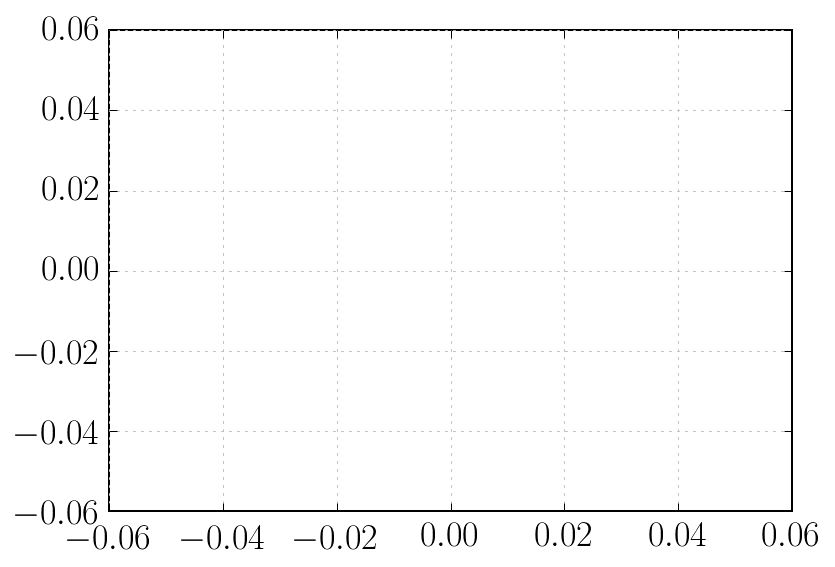

In [106]:
plt.plot(resp[:,0])
# plt.xlim(0,2)
# plt.ylim(-2,0)
# plt.plot(sys.times, resp[:,1])

In [ ]:
init_printing(False)
P3.pos_from(Origin).express(A)